## 1. Import Modules

In [1]:
import numpy as np
import os, sys
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.synapse_models.delay_connection import *
from snn_lib.synapse_models.exponential_synapse import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.connections.full_connection import *
from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel
from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
from snn_lib.plots.snn_recorder_plot import plot_neuron_record
from snn_lib.connections.custom_connection import CustomConnection, CustomOneToOneConnection, CustomAllToAllConnection

from snn_lib.connections.possibility_connection import *
from snn_lib.connections.all_to_all_connection import *

from snn_lib.monitors.network_recorder_manager import NetworkRecorderManager
from snn_lib.network.network_builder import NetworkBuilder


## 2. Prepare Network Builder

The `NetworkBuilder` class provides an interface to build a spiking neural network

In [3]:
network_builder = NetworkBuilder()

## [Optional] 3. Prepare Weights

In [4]:
# input (784 neuron) -> 28 reservoir x 28 neurons/reservoir -> 10 output neurons

n_input_neurons = 784
n_reservoirs = 28
n_neurons_per_reservoir = 28
n_output_neurons = 10

weights_reservoirs = np.zeros((n_reservoirs, n_neurons_per_reservoir, n_neurons_per_reservoir))

# [optional] set up weights. 
for i in range(0, n_reservoirs):
    for j in range(0, n_neurons_per_reservoir):
        for k in range(0, n_neurons_per_reservoir):
            weights_reservoirs[i, j, k] = float(0) # In i-th reservoir, the weight of j-th neuron connect to k-th neuron in the same reservoir
            
output_weights = np.zeros((n_reservoirs, n_neurons_per_reservoir, n_output_neurons))

for i in range(0, n_reservoirs):
    for j in range(0, n_neurons_per_reservoir):
        for k in range(0, n_output_neurons):
            output_weights[i, j, k] = float(0) # In i-th reservoir, the weight of j-th neuron connect to k-th neuron in the output neurons


## 4. Define Neurons

In [9]:
freq = 500
# n_microstates = 4
dt = 1 / freq
connection_possibility = 0.2
time_steps = 300


In [10]:
dummy_spikes = np.random.randint(0, 2, size=(int(time_steps), n_input_neurons)) # input spike train

# Generate 784 input neurons. The spike train is fixed, which is given by the dummy_spikes variable.
input_neuron = network_builder.add_neuron(f'input', FixedSpikeTrainNeuronModel(N = 784, spikes = dummy_spikes, hyperparameters = {'dt': dt}))

# Generate reservoir neurons
reservoir_neurons = []
for i in range(n_reservoirs):
    # build i-th reservoir
    reservoir_neuron_i = network_builder.add_neuron(f'reservoir_{i}', CurrentBasedLIFNeuron(n_neurons_per_reservoir, {'dt': dt}))
    reservoir_neurons.append(reservoir_neuron_i)

# Generate output neurons
output_neuron = network_builder.add_neuron('output', CurrentBasedLIFNeuron(n_output_neurons, {'dt': dt}))


## 5. Build Connections

In [11]:
# Build connections among reservoirs.

for i in range(n_reservoirs):
    for j in range(n_reservoirs):
        # Connection: inner reservoir.
        network_builder.add_connection((f'reservoir_{i}', f'reservoir_{j}', PossibilityConnection(reservoir_neurons[i], reservoir_neurons[j], connection_possibility), \
                                        DoubleExponentialSynapse(pre_N = n_neurons_per_reservoir, post_N =n_neurons_per_reservoir, dt = dt, td = 1e-2, tr = 5e-3)))

for i in range(n_reservoirs):
    # Connection: reservoir -> output.
    network_builder.add_connection((f'reservoir_{i}', f'output', AllToAllConnection(reservoir_neurons[i], output_neuron), DoubleExponentialSynapse(n_neurons_per_reservoir, 1,  dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: input -> reservoir.
for i in range(n_reservoirs):
    network_builder.add_connection((f'input', f'reservoir_{i}', CustomOneToOneConnection(input_neuron, reservoir_neurons[i], list(range(i * n_neurons_per_reservoir, i * n_neurons_per_reservoir + n_neurons_per_reservoir)), list(range(0, n_reservoirs))), 
                                    DoubleExponentialSynapse(n_input_neurons, n_neurons_per_reservoir, dt = dt, td = 1e-2, tr = 5e-3)))

network = network_builder.build_network()
network.initialize_network()


## 6. Try Simulation

In [12]:
network.reset_time()
for t in tqdm(range(time_steps)):
        network.forward_single_time_step(t, None)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 21.09it/s]


## 8. Build Recorders

In [13]:
train_recorder = NetworkRecorderManager(network.neurons, network.connections)

# As a simple example, only record output neuron's spike
train_recorder.add_neuron_recorder('neuron_spike_series',  lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: \
                                   current_record + [neuron._states[neuron._output_index]] if neuron_id == 'output' else None)


## 9. Simulation with Recorders

In [17]:
network.initialize_network(True)
train_recorder.initialize_recorders()

neuron_spike_series_recorder = train_recorder.get_neuron_recorder('neuron_spike_series')

epochs = 1
for epoch in range(epochs):
    network.reset_time()
    
    for t in tqdm(range(time_steps)):
            network.forward_single_time_step(t, train_recorder) # record as the 2nd argument


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.44it/s]


In [18]:
output_spikes = neuron_spike_series_recorder.record['output']
assert len(output_spikes) == time_steps
output_spikes = np.array(output_spikes)
output_spikes.shape

(300, 10)

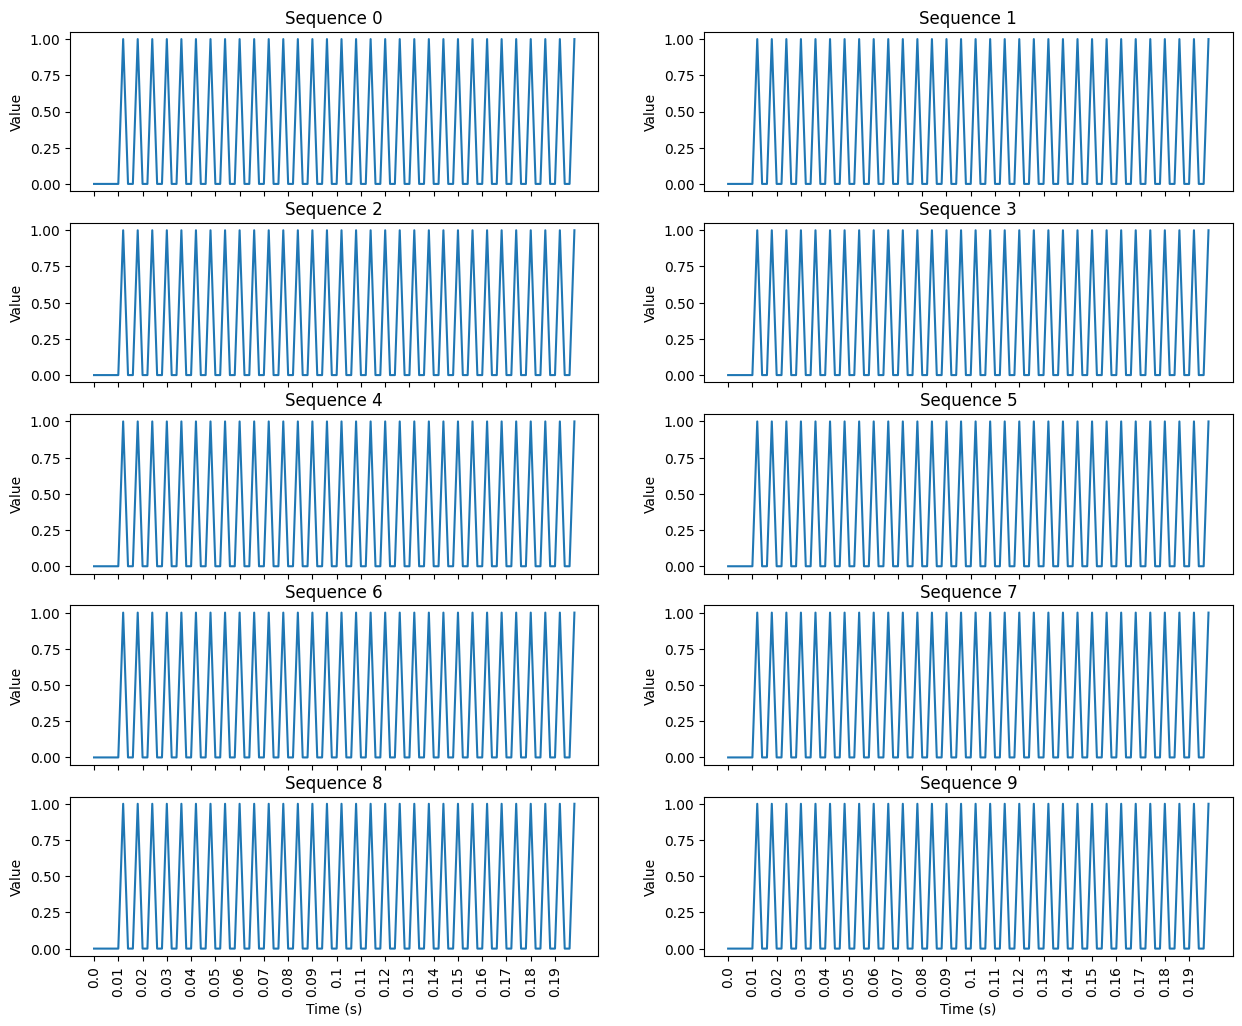

In [19]:
# Create 2x5 subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()  # to easily index in a single loop

for i in range(10):
    ax = axes[i]
    ax.plot(range(0, 100), output_spikes[:100, i])
    
    ax.set_title(f"Sequence {i}")
    if i >= 8:
        ax.set_xlabel("Time (s)")
        ax.set_xticks(range(0, 100, 5), np.array(range(0, 100, 5)) * dt, rotation=90)
    else:
        ax.set_xticks([])

    ax.set_ylabel("Value")


## 10. Supervised Training

## 10.1 Prepare expected spike trains

In [20]:
# Expected spike trains
output_spikes = np.zeros((time_steps, 10))
# Let 3-th and 6-th neuron spiking with interval 3.
output_spikes[::3, 2] = 1
output_spikes[::3, 5] = 1

## 10.2 Calculate Cost in Simulation

In [21]:
cost = 0
network.initialize_network(True)
neuron_spike_series_recorder = train_recorder.get_neuron_recorder('neuron_spike_series')

train_recorder.initialize_recorders()

epochs = 1
for epoch in range(epochs):
    network.reset_time()
    cost = 0
    for t in tqdm(range(time_steps)):
            network.forward_single_time_step(t, train_recorder)

            ## MSE
            cost += 0.5 * np.sum((output_spikes[t] - neuron_spike_series_recorder.record['output'][-1]) ** 2)
    print(f"End of an epoch {epoch}, Average Cost = %lf" % (cost / time_steps))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.62it/s]


End of an epoch 0, Average Cost = 1.313333


$\mathcal L = \frac12 \int_{-\infty}^t (S_{exp_{out}}(t) - S_{out}(t))^2 dt$

$\frac{\partial \mathcal L}{\partial w_{ij}} =\int_{-\infty}^t (S_{exp_{out}}(t) - S_{out}(t))\frac{\partial S_{out}(t)}{\partial w_{ij}} dt$

$\frac{\partial S_i(t)}{\partial w_{ij}}\approx \sigma'(U_i(t))\frac{\partial U_i(t)}{\partial w_{ij}} = \sigma'(U_i(t))(\epsilon * S_j(t))$



In [22]:
# helper functions for psesudo gradient descending
def surrogate_derivative_fastsigmoid(u, beta = 1, vthr = -50):
        return 1 / (1 + np.abs(beta * (u - vthr))) ** 2

def part_S_i_part_w_ij(t, recorder, connection, current_record):
    # if connection[0] != 'reservoir' or connection[1] != 'output':
    #     return []

    pre_neuron = recorder.neuron_map[connection[0]]
    new_record = current_record + [np.zeros(pre_neuron.n_neuron)]
    if t < 0:
        raise ValueError
    if t == 0:
        return new_record
    
    syapse_output_from_pre_neuron = connection[3]._states[connection[3]._output_index]
    post_neuron_id = connection[1]

    # post_neuron_potential need divide 1000, converting from mV to V.
    post_neuron_potential = recorder.get_neuron_recorder('neuron_mebrance_potential')[post_neuron_id][t]
    # syapse_output_from_pre_neuron shape = (n_post_neurons, n_pre_neurons)
    new_record[-1] = new_record[t - 1] + surrogate_derivative_fastsigmoid(post_neuron_potential).reshape((-1, syapse_output_from_pre_neuron.shape[0])).dot(syapse_output_from_pre_neuron)
    return new_record
    

In [23]:
# build recorder
train_recorder = NetworkRecorderManager(network.neurons, network.connections)

train_recorder.add_neuron_recorder('neuron_mebrance_potential', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron.INDEX_V]])

train_recorder.add_neuron_recorder('neuron_spike_series',  lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: \
                                   current_record + [neuron._states[neuron._output_index]])

train_recorder.add_connection_recorder('part_S_i_part_w_ij', lambda: [], \
                                   lambda t, recorder, connection, current_record, arg: part_S_i_part_w_ij(t, recorder, connection, current_record))

train_recorder.add_pre_requisite(record="part_S_i_part_w_ij", \
                                 requisite=[(NetworkRecorderManager.NEURON_RECORD, 'neuron_mebrance_potential'), \
                                            (NetworkRecorderManager.NEURON_RECORD, 'neuron_spike_series')])


In [25]:
cost = 0

# Parameter for a Adam optimizer
r = 0.001 
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
adam_states = {}

# Init a Adam optimizer
for connection in network.connections:
    key = connection[0] + "_" + connection[1]  # Same key used in recorder
    adam_states[key] = {
        'm': np.zeros_like(connection[2].W),
        'v': np.zeros_like(connection[2].W),
        't': 0
    }


network.initialize_network(True)
train_recorder.initialize_recorders()

neuron_spike_series_recorder = train_recorder.get_neuron_recorder('neuron_spike_series')
part_s_i_part_w_ij_recorder = train_recorder.get_connection_recorder('part_S_i_part_w_ij')


# Training
epochs = 5
costs = []
for epoch in range(epochs):
    network.reset_time()
    cost = 0
    train_recorder.initialize_recorders()
    for t in tqdm(range(time_steps)):
        network.forward_single_time_step(t, train_recorder)
        
        # retrieve necessary records.\n"
        output = neuron_spike_series_recorder['output'][t]
        
        # MSE Cost
        cost += 0.5 * np.sum((output_spikes[t] - neuron_spike_series_recorder.record['output'][-1]) ** 2)


        # Loop for updating parameters
        for connection in network.connections:    
            # connection ::= <pre_neuron, post_neuron, connection, synapse>
            connection_name = connection[0] + "_" + connection[1]
            part_s_i_part_w_ij_record = part_s_i_part_w_ij_recorder[connection_name][t]

            # Step Adam optimization
            state = adam_states[connection_name]
            grad = part_s_i_part_w_ij_record
            
            state['t'] += 1
            state['m'] = beta1 * state['m'] + (1-beta1) * grad
            state['v'] = beta2 * state['v'] + (1-beta2) * (grad**2)
            
            m_hat = state['m'] / (1 - beta1**state['t'])
            v_hat = state['v'] / (1 - beta2**state['t'])

            # Update parameters
            connection[2].W -= r * m_hat / (np.sqrt(v_hat) + epsilon)

        
    print(f"End of an epoch {epoch}, Average Cost = %lf" % (cost / time_steps))
    costs.append(cost / time_steps)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:27<00:00,  3.44it/s]


End of an epoch 0, Average Cost = 0.656667


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:20<00:00,  3.70it/s]


End of an epoch 1, Average Cost = 0.550000


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:24<00:00,  3.53it/s]


End of an epoch 2, Average Cost = 0.446667


 26%|█████████████████████▎                                                           | 79/300 [00:22<01:03,  3.46it/s]


KeyboardInterrupt: 

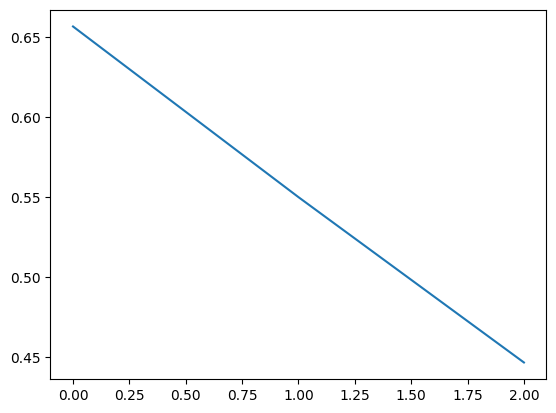

In [26]:
# Plot the cost records
plt.plot(range(len(costs)), costs)

In [27]:
# Perform simulation again after training.

network.initialize_network(True)
train_recorder.initialize_recorders()

neuron_spike_series_recorder = train_recorder.get_neuron_recorder('neuron_spike_series')

network.reset_time()
    
for t in tqdm(range(time_steps)):
    network.forward_single_time_step(t, train_recorder) # record as the 2nd argument


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:00<00:00,  4.96it/s]


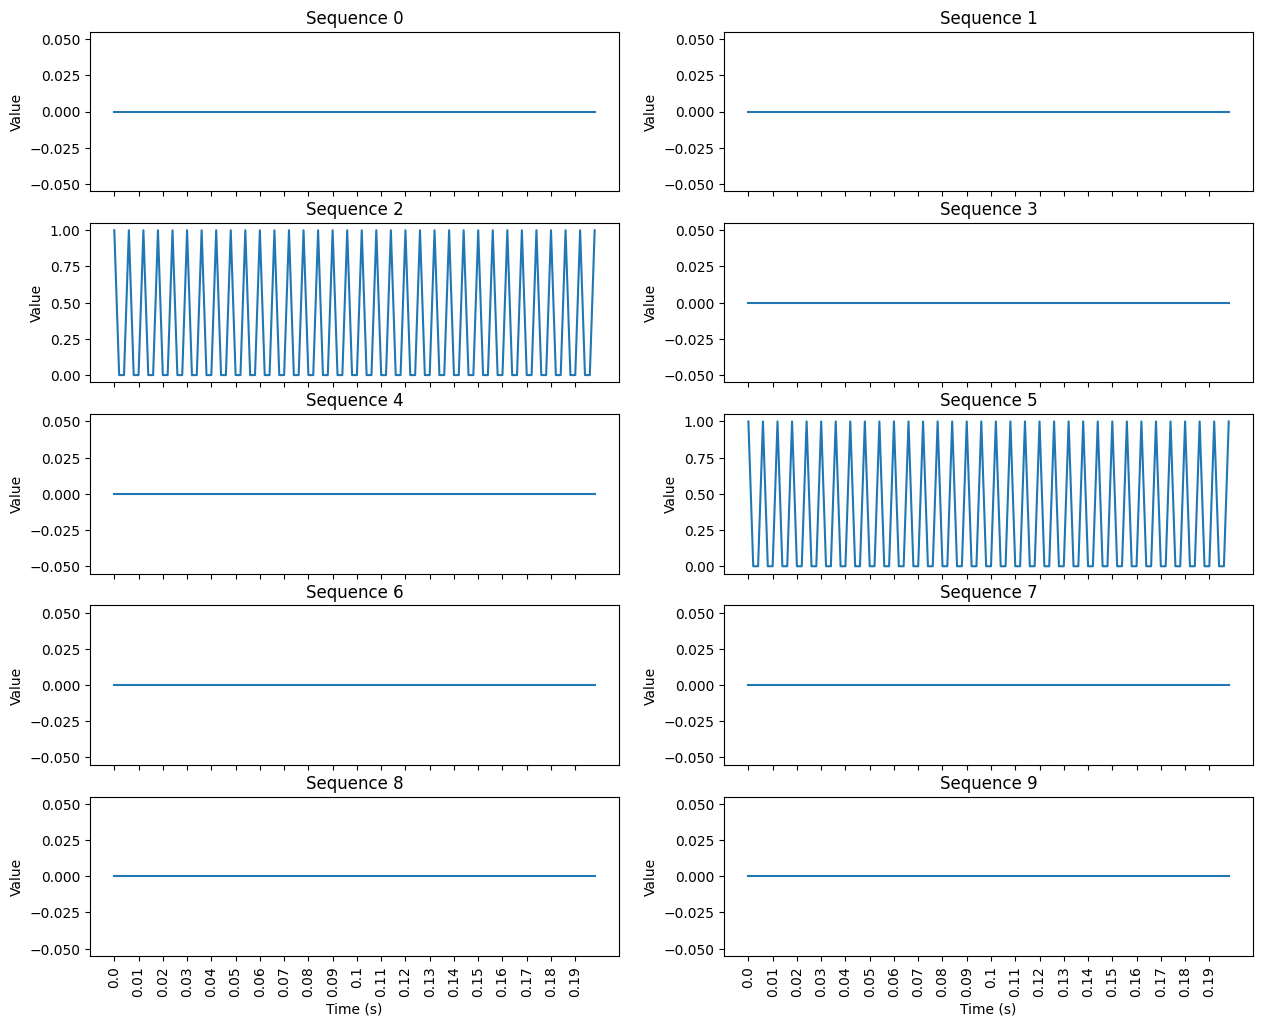

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()  # to easily index in a single loop

for i in range(10):
    ax = axes[i]
    ax.plot(range(0, 100), output_spikes[:100, i])
    
    ax.set_title(f"Sequence {i}")
    if i >= 8:
        ax.set_xlabel("Time (s)")
        ax.set_xticks(range(0, 100, 5), np.array(range(0, 100, 5)) * dt, rotation=90)
    else:
        ax.set_xticks([])

    ax.set_ylabel("Value")
